# Import library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/diabetes_prediction_dataset.csv


In [4]:
df = pd.read_csv('/kaggle/input/diabetes_prediction_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


# Data Understanding

In [5]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
df.duplicated().sum()

3854

In [7]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [8]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Terdapat keanehan: 
- minimal umur adalah 0.08
- max bmi adalah 95.69 sedangkan Q3 29.58
- max blood_glucose adalah 300 sedangkan Q3 159

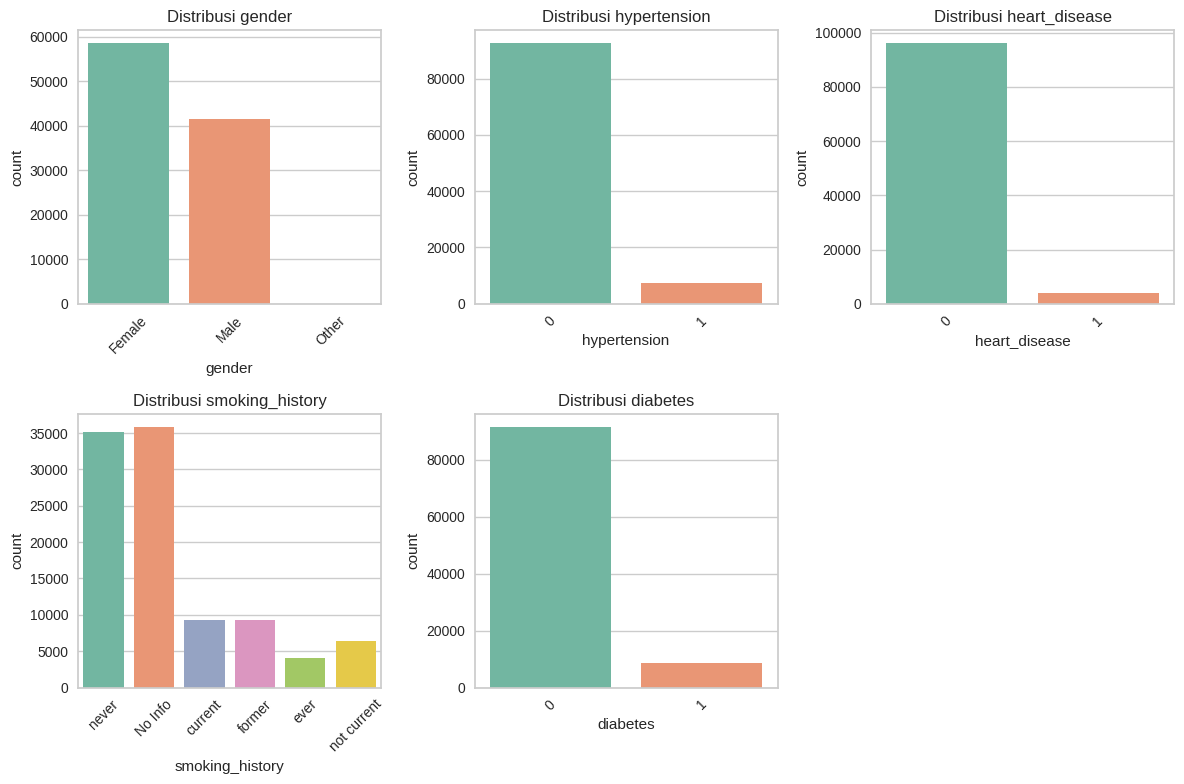

In [9]:
categorical = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']

# create bar chat
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(categorical):
    sns.countplot(data=df, x=col, ax=axs[i], palette="Set2")
    axs[i].set_title(f'Distribusi {col}')
    axs[i].tick_params(axis='x', rotation=45)

# Hilangkan axis yang tidak terpakai
for j in range(len(categorical), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


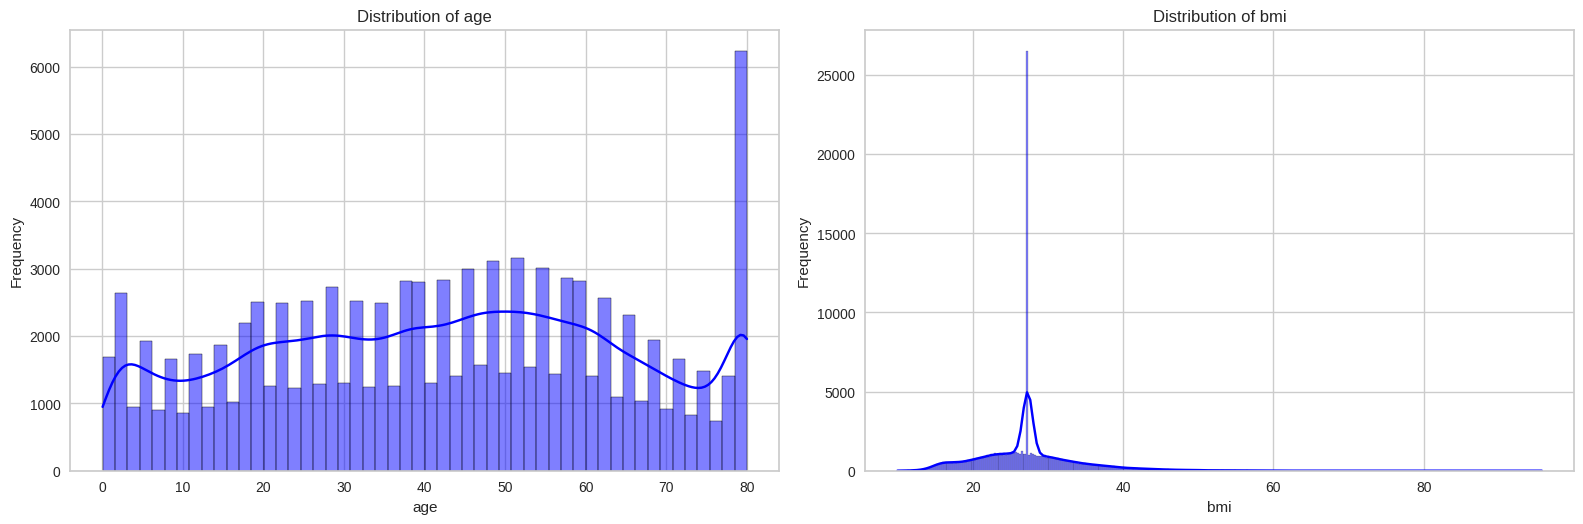

In [10]:
numerical = ['age', 'bmi']

# Create histogram
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

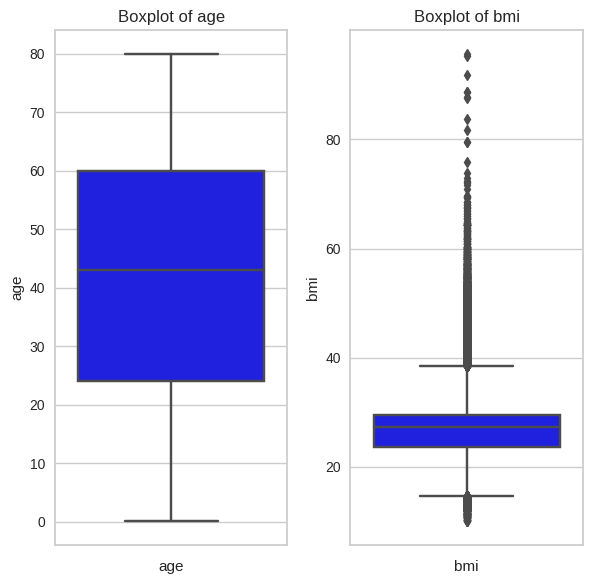

In [11]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=df, y=col, color='blue', orient='v')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

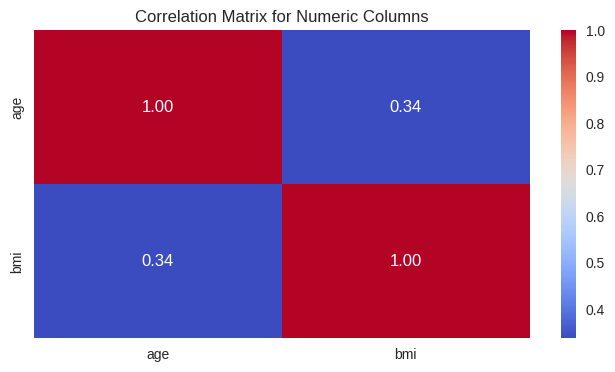

In [12]:
plt.figure(figsize=(8, 4))
correlation_matrix = df[numerical].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numeric Columns')
plt.show()

# Data Preparation

In [13]:
df.drop(df[df["gender"]=="Other"].index,inplace=True)
df.reset_index(drop=True,inplace=True)

In [14]:
df.drop(columns=['HbA1c_level', 'blood_glucose_level'], inplace=True)

In [15]:
df.drop_duplicates()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0
...,...,...,...,...,...,...,...
99976,Female,36.0,0,0,No Info,24.60,0
99978,Female,2.0,0,0,No Info,17.37,0
99979,Male,66.0,0,0,former,27.83,0
99980,Female,24.0,0,0,never,35.42,0


In [16]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_cleaned = remove_outliers_iqr(df, numerical)

In [17]:
# One-hot encode smoking_history
df_cleaned = pd.get_dummies(df_cleaned, columns=['smoking_history'], prefix='smoking_history', dtype=int)

# For gender (binary), label encode as 0/1
encoder = LabelEncoder()
df_cleaned['gender'] = encoder.fit_transform(df_cleaned['gender'])

In [18]:
df_cleaned = df_cleaned.rename(columns={
    "smoking_history_No Info": "no_info_smoke",
    "smoking_history_current": "current_smoke",
    "smoking_history_ever": "ever_smoke",
    "smoking_history_former": "former_smoke",
    "smoking_history_never": "never_smoke",
    "smoking_history_not current": "no_current_smoke",
})

In [19]:
scaler = StandardScaler()
df_cleaned[numerical] = scaler.fit_transform(df_cleaned[numerical])

In [20]:
df_cleaned.head()

,gender,age,hypertension,heart_disease,bmi,diabetes,no_info_smoke,current_smoke,ever_smoke,former_smoke,never_smoke,no_current_smoke
0,0,1.680654,0,1,-0.247416,0,0,0,0,0,1,0
1,0,0.531683,0,0,0.187953,0,1,0,0,0,0,0
2,1,-0.617288,0,0,0.187953,0,0,0,0,0,1,0
3,0,-0.263758,0,0,-0.603070,0,0,1,0,0,0,0
4,1,1.503890,1,1,-1.279630,0,0,1,0,0,0,0


# Clustering

In [21]:
x = df_cleaned.drop(columns=['diabetes'])
x = x.values
print(x)

[[ 0.          1.68065441  0.         ...  0.          1.
   0.        ]
 [ 0.          0.5316834   0.         ...  0.          0.
   0.        ]
 [ 1.         -0.61728761  0.         ...  0.          1.
   0.        ]
 ...
 [ 1.          1.06197771  0.         ...  1.          0.
   0.        ]
 [ 0.         -0.79405238  0.         ...  0.          1.
   0.        ]
 [ 0.          0.66425698  0.         ...  0.          0.
   0.        ]]


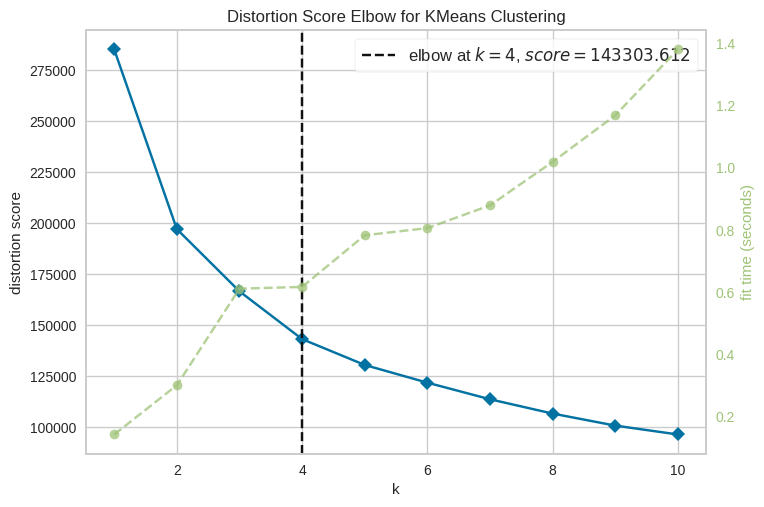

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
kmeans = KMeans(n_init=10)
visualizer = KElbowVisualizer(kmeans, k=(1, 11), random_state=42)
visualizer.fit(x)
visualizer.show()

In [23]:
silhouette_scores_before = []
k_range = range(2, 11)

# Use a sample to speed up silhouette score computation
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(x)
    score = silhouette_score(x, cluster_labels, sample_size=15000, random_state=42)
    silhouette_scores_before.append(score)


# Metric Evaluation

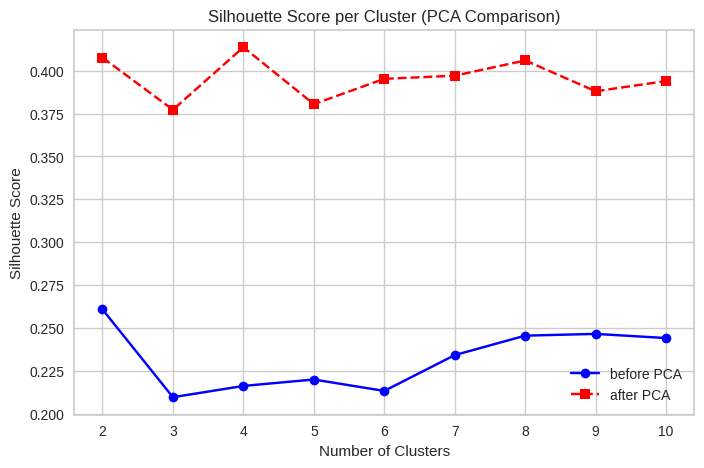

In [24]:
# PCA for dimension reduction
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

# K-Means after PCA
silhouette_scores_after = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(x_pca)
    silhouette_scores_after.append(silhouette_score(x_pca, cluster_labels, sample_size=15000, random_state=42))

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores_before, marker='o',  label='before PCA', color='blue')
plt.plot(k_range, silhouette_scores_after, marker='s', linestyle='dashed', label='after PCA', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Cluster (PCA Comparison)')
plt.legend()
plt.show()

In [25]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
X_cluster_labels = kmeans.fit_predict(x)

# Random Forest untuk memilih fitur terpenting
def random_forest_selection(X, y, feature_names, n_features=5):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[-n_features:]  # top n
    selected_features = [feature_names[i] for i in indices]
    return X[:, indices], selected_features

# Dapatkan nama kolom fitur
feature_names = df_cleaned.columns.tolist()

# Seleksi fitur
X_selected, selected_features = random_forest_selection(x, X_cluster_labels, feature_names)

print("📌 Selected Features (Embedded - Random Forest):", selected_features)

📌 Selected Features (Embedded - Random Forest): ['heart_disease', 'hypertension', 'diabetes', 'age', 'bmi']


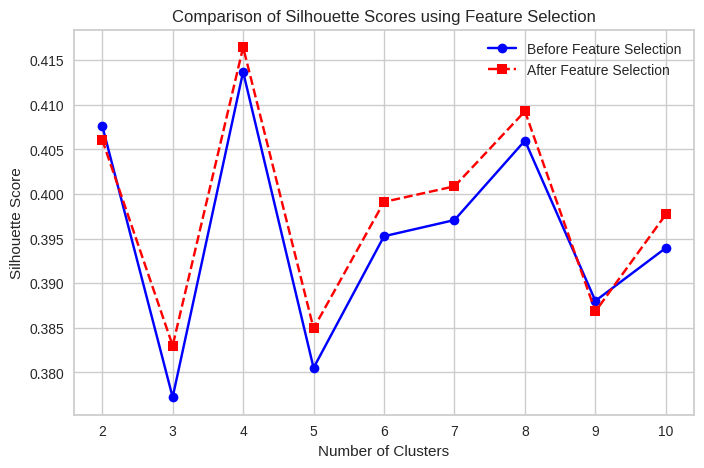

In [26]:
df_cleaned_embedded = df_cleaned.drop(columns=['diabetes'])
selected_features.remove('diabetes')

x_feature_selection = df_cleaned_embedded[selected_features].values

pca = PCA(n_components=2)
x_pca_feature_selection = pca.fit_transform(x_feature_selection)

silhouette_scores_after_feature_selection = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(x_pca_feature_selection)
    silhouette_scores_after_feature_selection.append(silhouette_score(x_pca_feature_selection, cluster_labels, sample_size=15000, random_state=42))


plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores_after, marker='o', label='Before Feature Selection', color='blue')
plt.plot(k_range, silhouette_scores_after_feature_selection, marker='s', linestyle='--', label='After Feature Selection', color='red')

# Labels, Title, and Legend
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Scores using Feature Selection')
plt.legend()
plt.show()

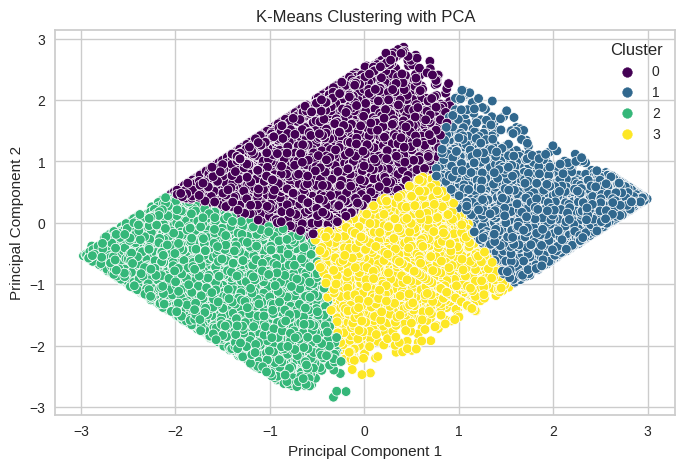

Final Silhouette Score: 0.41330821496421016


In [27]:
df_cluster = df_cleaned
# Visualize Cluster
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(x_pca_feature_selection)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=x_pca_feature_selection[:, 0], y=x_pca_feature_selection[:, 1], hue=df_cluster['Cluster'], palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering with PCA')
plt.show()

silhouette_avg = silhouette_score(x_pca, kmeans.labels_)
print(f"Final Silhouette Score: {silhouette_avg}")

In [28]:
# Salin DataFrame untuk analisis
df_clusters = df_cluster.copy()

# Pastikan scaler dan gender_encoder sudah tersedia
assert scaler is not None, "Scaler belum didefinisikan"
assert encoder is not None, "Gender encoder belum didefinisikan"

# Fitur numerik yang sudah diskalakan
numeric_features = ['age', 'bmi']

# Inverse transform numerik ke skala asli
df_clusters[numeric_features] = scaler.inverse_transform(df_clusters[numeric_features])

# Decode label encoding gender
df_clusters['gender'] = encoder.inverse_transform(df_clusters['gender'].astype(int))

# Daftar fitur one-hot smoking
smoking_features = [
    'no_info_smoke', 'current_smoke', 'ever_smoke',
    'former_smoke', 'never_smoke', 'no_current_smoke'
]

# Fungsi decode smoking history
def decode_smoking(row):
    for feature in smoking_features:
        if row.get(feature, 0) == 1:
            return feature
    return 'unknown'

# Buat kolom smoking_history dari decoding one-hot
df_clusters['smoking_history'] = df_clusters.apply(decode_smoking, axis=1)

# Drop kolom-kolom one-hot smoking yang lama
df_clusters.drop(columns=smoking_features, inplace=True)

# Pindahkan kolom 'diabetes' ke posisi paling kanan sebelum 'Cluster'
cols = [c for c in df_clusters.columns if c != 'diabetes'] + ['diabetes']
df_clusters = df_clusters[cols]

# Pindahkan kolom 'Cluster' ke posisi paling kanan
cols = [c for c in df_clusters.columns if c != 'Cluster'] + ['Cluster']
df_clusters = df_clusters[cols]

# Pastikan kolom 'Cluster' ada
assert 'Cluster' in df_clusters.columns, "Kolom 'Cluster' belum ada di DataFrame."

In [29]:
df_clusters.head()

,gender,age,hypertension,heart_disease,bmi,smoking_history,diabetes,Cluster
0,Female,80.0,0,1,25.19,never_smoke,0,0
1,Female,54.0,0,0,27.32,no_info_smoke,0,0
2,Male,28.0,0,0,27.32,never_smoke,0,3
3,Female,36.0,0,0,23.45,current_smoke,0,3
4,Male,76.0,1,1,20.14,current_smoke,0,0


In [30]:
# Misal ini fitur numerik dan kategorikal sesuai data kamu
numeric_features = ['age', 'bmi']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

# Grouping berdasarkan cluster
grouped = df_clusters.groupby('Cluster')

print("--- Analisis Karakteristik Setiap Cluster ---")

for cluster_id, group in grouped:
    print(f"\n✨ Cluster {cluster_id}:")
    print(f"  Jumlah Anggota: {len(group)} data")
    print("-" * 30)

    # Analisis Fitur Kategorikal (Distribusi Frekuensi)
    print("  --- Fitur Kategorikal ---")
    for cat in categorical_features:
        print(f"  {cat.replace('_', ' ').capitalize()}:")
        # Menampilkan value counts dan persentase
        value_counts = group[cat].value_counts(normalize=True) * 100
        for val, percentage in value_counts.items():
            print(f"    - {val}: {percentage:.2f}%")
    
    # Analisis Fitur Numerik (Rata-rata dan Standar Deviasi)
    print("\n  --- Fitur Numerik ---")
    for num in numeric_features:
        avg_val = group[num].mean()
        std_val = group[num].std() # Menambahkan standar deviasi
        print(f"  {num.replace('_', ' ').capitalize()}:")
        print(f"    - Rata-rata: {avg_val:.2f}")
        print(f"    - Standar Deviasi: {std_val:.2f}")
    
    print("=" * 50)

--- Analisis Karakteristik Setiap Cluster ---

✨ Cluster 0:
  Jumlah Anggota: 32173 data
------------------------------
  --- Fitur Kategorikal ---
  Gender:
    - Female: 58.51%
    - Male: 41.49%
  Hypertension:
    - 0: 87.37%
    - 1: 12.63%
  Heart disease:
    - 0: 91.64%
    - 1: 8.36%
  Smoking history:
    - never_smoke: 33.54%
    - no_info_smoke: 30.34%
    - former_smoke: 14.21%
    - current_smoke: 9.17%
    - no_current_smoke: 7.90%
    - ever_smoke: 4.83%

  --- Fitur Numerik ---
  Age:
    - Rata-rata: 63.95
    - Standar Deviasi: 11.06
  Bmi:
    - Rata-rata: 26.14
    - Standar Deviasi: 2.62

✨ Cluster 1:
  Jumlah Anggota: 15759 data
------------------------------
  --- Fitur Kategorikal ---
  Gender:
    - Female: 56.95%
    - Male: 43.05%
  Hypertension:
    - 0: 99.86%
    - 1: 0.14%
  Heart disease:
    - 0: 99.90%
    - 1: 0.10%
  Smoking history:
    - no_info_smoke: 59.76%
    - never_smoke: 29.08%
    - current_smoke: 4.48%
    - no_current_smoke: 3.57%
    - 

✨ Cluster 0 — Populasi Lansia dengan Riwayat Kesehatan Kompleks
Deskripsi:
Kelompok ini didominasi oleh individu usia lanjut (rata-rata ~64 tahun). Meski BMI rata-rata masih normal, prevalensi hipertensi (12.63%) dan penyakit jantung (8.36%) cukup mencolok. Riwayat merokok beragam, terutama pada kategori never_smoke dan no_info_smoke.
Kelompok ini merepresentasikan lansia dengan catatan kesehatan yang perlu perhatian khusus.

✨ Cluster 1 — Anak dan Remaja dalam Kondisi Fisik Optimal
Deskripsi:
Kelompok dengan rata-rata usia sangat muda (~14 tahun) dan BMI rendah (18.91). Hampir seluruhnya tidak memiliki riwayat hipertensi, penyakit jantung, maupun kebiasaan merokok.
Cluster ini menggambarkan populasi anak dan remaja dengan profil kesehatan yang ideal.

✨ Cluster 2 — Dewasa dengan Pola Hidup Kurang Sehat
Deskripsi:
Berisi individu dewasa (rata-rata usia ~51 tahun) dengan BMI sangat tinggi (~33.73). Banyak anggota kelompok ini memiliki riwayat hipertensi (13.67%) dan penyakit jantung (5.62%), serta riwayat merokok yang cukup tersebar.
Kelompok ini mencerminkan gaya hidup yang kurang sehat dan rentan terhadap penyakit metabolik.

✨ Cluster 3 — Dewasa Muda Aktif dan Relatif Sehat
Deskripsi:
Kelompok ini terdiri dari individu dewasa muda (usia ~28 tahun) dengan BMI normal, serta prevalensi hipertensi dan penyakit jantung yang sangat rendah. Riwayat merokok cukup bervariasi, namun mayoritas tidak merokok.
Kelompok ini merepresentasikan usia produktif dengan gaya hidup relatif seimbang dan aktif.


In [31]:
df_clusters['Cluster'].value_counts()

Cluster
0    32173
3    29719
1    15759
2    15246
Name: count, dtype: int64

In [32]:
df_clusters.to_csv('diabetes_with_cluster2.csv', index=False)